In [1]:
import pickle
import numpy as np
import awkward
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import uproot
import boost_histogram as bh
import mplhep
import glob
import os
import vector
import shutil
from matplotlib.lines import Line2D
import tqdm

mplhep.style.use("CMS")

matplotlib.rcParams['axes.labelsize'] = 35
legend_fontsize = 30
sample_label_fontsize = 30
addtext_fontsize = 25

In [2]:
jet_label_coords = 0.01, 0.84
jet_label_coords_single = 0.01, 0.88
sample_label_coords = 0.01, 0.97
jet_label_ak4 = "AK4 jets"
jet_label_ak8 = "AK8 jets"
reco_gen_ratio = "Rec. / Gen."

default_cycler = plt.rcParams['axes.prop_cycle']
pf_color = list(default_cycler)[1]["color"]
mlpf_color = list(default_cycler)[2]["color"]

In [3]:
import sys

sys.path += ["../../mlpf/plotting/"]
sys.path += ["../../mlpf/"]

import plot_utils
import jet_utils

from plot_utils import ELEM_LABELS_CMS, ELEM_NAMES_CMS
from plot_utils import CLASS_LABELS_CMS, CLASS_NAMES_CMS
from plot_utils import experiment_label, sample_label

def cms_label(ax):
    return experiment_label(ax, experiment="CMS", tag1="Simulation Preliminary", tag2="Run 3 (13.6 TeV)", x1=0.13)

In [4]:
# fi = uproot.open("/scratch/local/joosep/mlpf/results/cms/CMSSW_15_0_5_mlpf_v2.5.0_p01_603dc5/TTbar_PU_mlpfpu/step4_NANO_btv_1.root").get("Events")
# for k in sorted(fi.keys()):
#     print(k)

In [5]:
def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    return h1

def load_nano(fn):
    # print(fn)
    tt = uproot.open(fn).get("Events")
    ret = {}
    for k in [
        "Jet_pt", "Jet_genJetIdx", "Jet_rawFactor",
        #"JetCHS_pt", "JetCHS_genJetIdx", "JetCHS_rawFactor",
        "FatJet_pt", "FatJet_genJetAK8Idx", "FatJet_rawFactor",
        "GenJet_pt",
        "GenJetAK8_pt",
        "GenMET_pt", "GenMET_phi",
        "PFMET_pt", "PFMET_phi",
        "PuppiMET_pt", "PuppiMET_phi",
        "RawPFMET_pt", "RawPFMET_phi",
        "Pileup_nPU", "Pileup_nTrueInt",
    ]:
        ret[k] = tt.arrays(k)[k]
    return [ret, ]

def varbins(*args):
    newlist = []
    for arg in args[:-1]:
        newlist.append(arg[:-1])
    newlist.append(args[-1])
    return np.concatenate(newlist)

def get_hist_and_merge(files, histname):
    hists = []
    for fn in files:
        fi = uproot.open(fn)
        h = fi[histname].to_boost()
        hists.append(h)
    return sum(hists[1:], hists[0])

from scipy.optimize import curve_fit

def Gauss(x, a, x0, sigma):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))

In [6]:
folder = "TTbar_noPU_13p6_v2"
physics_process = "cms_pf_ttbar_nopu"

if physics_process == "cms_pf_qcd_nopu" or physics_process == "cms_pf_qcd" or physics_process == "cms_pf_photonjet":
    jet_bins = varbins(np.linspace(10, 100, 21), np.linspace(100, 200, 5), np.linspace(200, 1000, 5))
    fatjet_bins = varbins(np.linspace(100, 200, 5), np.linspace(200, 1000, 5))
    met_bins = varbins(np.linspace(0, 150, 21), np.linspace(150, 500, 5))
    pt_bins_for_pu = [(0, 30), (30, 60), (60, 100), (100, 200), (200,5000)]

if physics_process == "cms_pf_ttbar" or physics_process == "cms_pf_ttbar_nopu":
    jet_bins = varbins(np.linspace(10, 100, 21), np.linspace(100, 250, 5))
    fatjet_bins = varbins(np.linspace(100, 400, 5))
    met_bins = varbins(np.linspace(0, 150, 21), np.linspace(150, 250, 5))
    pt_bins_for_pu = [(0, 30), (30, 60), (60, 100), (100, 200), (200,5000)]

if physics_process == "cms_pf_photonjet":
    jet_bins = varbins(np.linspace(10, 60, 21), np.linspace(60, 120, 2))
    fatjet_bins = varbins(np.linspace(0, 1000, 2))
    met_bins = varbins(np.linspace(0, 200, 41))
    pt_bins_for_pu = [(0, 30), (30, 60), (60, 100)]
    
outpath = "cmssw/{}".format(folder)
shutil.rmtree(outpath, ignore_errors=True)
os.makedirs(outpath)

In [7]:
pf_files = glob.glob("/home/joosep/mlpf/results/cms/CMSSW_15_0_5_mlpf_v2.5.0_p01_f8ae2f/cuda_False/{}_pf/step4_NANO_btv_*.root".format(folder))
mlpf_files = glob.glob("/home/joosep/mlpf/results/cms/CMSSW_15_0_5_mlpf_v2.5.0_p01_f8ae2f/cuda_False/{}_mlpfpu/step4_NANO_btv_*.root".format(folder))
#mlpf_new_files = glob.glob("/scratch/local/joosep/mlpf/results/cms/CMSSW_15_0_5_mlpf_v2.5.0_p01/{}_mlpfpu/step4_NANO_btv_*.root".format(folder))

pf_files_d = {os.path.basename(fn): fn for fn in pf_files}
mlpf_files_d = {os.path.basename(fn): fn for fn in mlpf_files}
#mlpf_new_files_d = {os.path.basename(fn): fn for fn in mlpf_new_files}

In [8]:
len(pf_files_d), len(mlpf_files_d)#, len(mlpf_new_files)

(874, 874)

In [9]:
common_files = list(set(pf_files_d.keys()).intersection(set(mlpf_files_d.keys())))
len(common_files)

872

In [10]:
from concurrent.futures import ProcessPoolExecutor
def load_multiprocess(files, max_workers=None):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm.tqdm(executor.map(load_nano, files), total=len(files)))
    successful_results = [r for r in results if r is not None]

    return awkward.concatenate(successful_results)

In [11]:
data_baseline = load_multiprocess([pf_files_d[fn] for fn in common_files], 16)
data_mlpf =  load_multiprocess([mlpf_files_d[fn] for fn in common_files], 16)
#data_mlpf_new = awkward.Array(sum([load_nano(mlpf_new_files_d[fn]) for fn in common_files], []))

data_baseline = awkward.Array({k: awkward.flatten(data_baseline[k], axis=1) for k in data_baseline.fields})
data_mlpf = awkward.Array({k: awkward.flatten(data_mlpf[k], axis=1) for k in data_mlpf.fields})
#data_mlpf_new = awkward.Array({k: awkward.flatten(data_mlpf_new[k], axis=1) for k in data_mlpf_new.fields})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [01:20<00:00, 10.85it/s]


## Jets

### Jet $p_T$ spectrum

In [12]:
# data_baseline["JetCHS_pt_raw"] = data_baseline["JetCHS_pt"]*(1.0 - data_baseline["JetCHS_rawFactor"])
# data_mlpf["JetCHS_pt_raw"] = data_mlpf["JetCHS_pt"]*(1.0 - data_mlpf["JetCHS_rawFactor"])
# data_mlpf_new["JetCHS_pt_raw"] = data_mlpf_new["JetCHS_pt"]*(1.0 - data_mlpf_new["JetCHS_rawFactor"])

data_baseline["Jet_pt_raw"] = data_baseline["Jet_pt"]*(1.0 - data_baseline["Jet_rawFactor"])
data_mlpf["Jet_pt_raw"] = data_mlpf["Jet_pt"]*(1.0 - data_mlpf["Jet_rawFactor"])
#data_mlpf_new["Jet_pt_raw"] = data_mlpf_new["Jet_pt"]*(1.0 - data_mlpf_new["Jet_rawFactor"])

data_baseline["FatJet_pt_raw"] = data_baseline["FatJet_pt"]*(1.0 - data_baseline["FatJet_rawFactor"])
data_mlpf["FatJet_pt_raw"] = data_mlpf["FatJet_pt"]*(1.0 - data_mlpf["FatJet_rawFactor"])
#data_mlpf_new["FatJet_pt_raw"] = data_mlpf_new["FatJet_pt"]*(1.0 - data_mlpf_new["FatJet_rawFactor"])

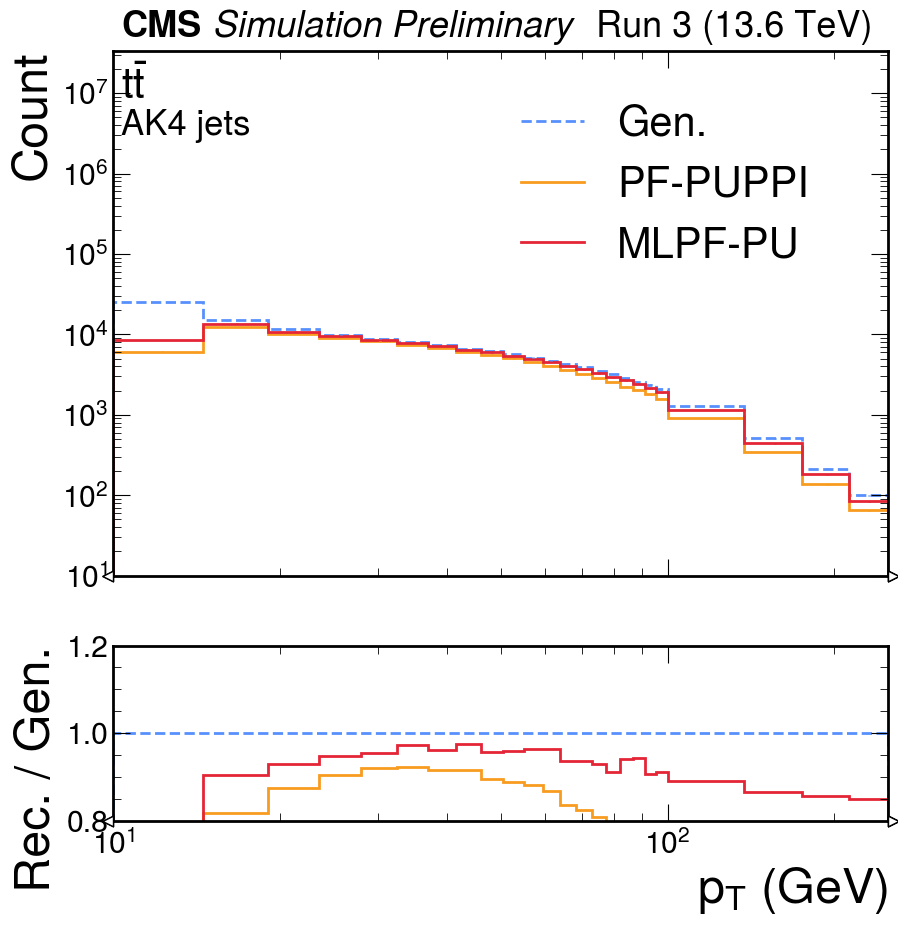

In [13]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True)

h0 = to_bh(awkward.flatten(data_baseline["GenJet_pt"]), jet_bins)
h1 = to_bh(awkward.flatten(data_baseline["Jet_pt_raw"]), jet_bins)
h2 = to_bh(awkward.flatten(data_mlpf["Jet_pt_raw"]), jet_bins)
#h3 = to_bh(awkward.flatten(data_mlpf_new["Jet_pt_raw"]), jet_bins)

plt.sca(a0)
x0 = mplhep.histplot(h0, histtype="step", lw=2, label="Gen.", binwnorm=1.0, ls="--")
x1 = mplhep.histplot(h1, histtype="step", lw=2, label="PF-PUPPI", binwnorm=1.0, ls="-")
x2 = mplhep.histplot(h2, histtype="step", lw=2, label="MLPF-PU", binwnorm=1.0, ls="-")
#x3 = mplhep.histplot(h3, histtype="step", lw=2, label="MLPF-PU p<0.1", binwnorm=1.0, ls="-")

# plt.xscale("log")
plt.yscale("log")
cms_label(a0)
sample_label(a0, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
a0.text(jet_label_coords[0], jet_label_coords[1], jet_label_ak4, transform=a0.transAxes, fontsize=addtext_fontsize)
handles, labels = a0.get_legend_handles_labels()
handles = [x0[0].stairs, x1[0].stairs, x2[0].stairs]
a0.legend(handles, labels, loc=(0.5, 0.55), fontsize=legend_fontsize)
plt.ylim(10, a0.get_ylim()[1]*1000)
plt.ylabel("Count")

plt.sca(a1)
mplhep.histplot(h0 / h0, histtype="step", lw=2, ls="--")
mplhep.histplot(h1 / h0, histtype="step", lw=2, ls="-")
mplhep.histplot(h2 / h0, histtype="step", lw=2, ls="-")
#mplhep.histplot(h3 / h0, histtype="step", lw=2, ls="-")
plt.ylim(0.8, 1.2)
plt.ylabel(reco_gen_ratio)
plt.xlabel(plot_utils.labels["pt"])

plt.xscale("log")

plt.xlim(min(jet_bins), max(jet_bins))
plt.savefig("{}/ak4_jet_pt.pdf".format(outpath))

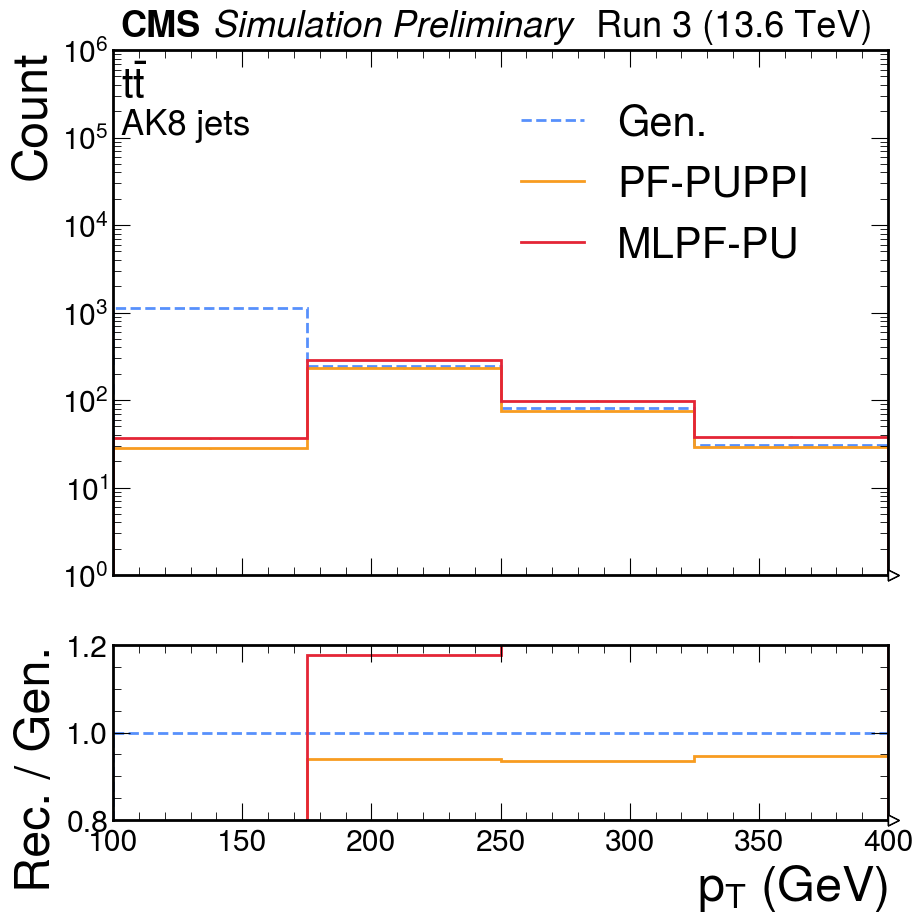

In [14]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True)

h0 = to_bh(awkward.flatten(data_baseline["GenJetAK8_pt"]), fatjet_bins)
h1 = to_bh(awkward.flatten(data_baseline["FatJet_pt"]), fatjet_bins)
h2 = to_bh(awkward.flatten(data_mlpf["FatJet_pt"]), fatjet_bins)
#h3 = to_bh(awkward.flatten(data_mlpf_new["FatJet_pt"]), fatjet_bins)

plt.sca(a0)
x0 = mplhep.histplot(h0, histtype="step", lw=2, label="Gen.", binwnorm=1.0, ls="--")
x1 = mplhep.histplot(h1, histtype="step", lw=2, label="PF-PUPPI", binwnorm=1.0, ls="-")
x2 = mplhep.histplot(h2, histtype="step", lw=2, label="MLPF-PU", binwnorm=1.0, ls="-")
#x3 = mplhep.histplot(h3, histtype="step", lw=2, label="MLPF-PU new", binwnorm=1.0, ls="-")

# plt.xscale("log")
plt.yscale("log")
cms_label(a0)
sample_label(a0, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
a0.text(jet_label_coords[0], jet_label_coords[1], "AK8 jets", transform=a0.transAxes, fontsize=addtext_fontsize)
handles, labels = a0.get_legend_handles_labels()
handles = [x0[0].stairs, x1[0].stairs, x2[0].stairs]
a0.legend(handles, labels, loc=(0.5, 0.55), fontsize=legend_fontsize)
plt.ylim(1, 10**6)
plt.ylabel("Count")

plt.sca(a1)
mplhep.histplot(h0 / h0, histtype="step", lw=2, ls="--")
mplhep.histplot(h1 / h0, histtype="step", lw=2, ls="-")
mplhep.histplot(h2 / h0, histtype="step", lw=2, ls="-")
#mplhep.histplot(h3 / h0, histtype="step", lw=2, ls="-")
plt.ylim(0.8,1.2)
plt.ylabel(reco_gen_ratio)
plt.xlabel(plot_utils.labels["pt"])

#plt.xscale("log")

plt.xlim(min(fatjet_bins), max(fatjet_bins))
plt.savefig("{}/ak8_jet_pt.pdf".format(outpath))

### Jet response, matching to gen-jets

In [15]:
# plt.figure()
# ax = plt.axes()

# b = np.linspace(0,2,200)

# cms_label(ax)
# sample_label(ax, physics_process, x=0.02, y=0.92)
# ax.text(0.02, 0.94, "AK4 CHS jets", transform=ax.transAxes)

# msk = data_baseline["JetCHS_genJetIdx"]!=-1
# jet_response_pf = awkward.flatten(data_baseline["JetCHS_pt_raw"][msk] / data_baseline["GenJet_pt"][data_baseline["JetCHS_genJetIdx"]][msk])
# msk = data_mlpf["JetCHS_genJetIdx"]!=-1
# jet_response_mlpf = awkward.flatten(data_mlpf["JetCHS_pt_raw"][msk] / data_mlpf["GenJet_pt"][data_mlpf["JetCHS_genJetIdx"]][msk])
# msk = data_mlpf_new["JetCHS_genJetIdx"]!=-1
# jet_response_mlpf_new = awkward.flatten(data_mlpf_new["JetCHS_pt_raw"][msk] / data_mlpf_new["GenJet_pt"][data_mlpf_new["JetCHS_genJetIdx"]][msk])

# h0 = to_bh(jet_response_pf, b)
# h1 = to_bh(jet_response_mlpf, b)
# h2 = to_bh(jet_response_mlpf_new, b)

# plt.plot([], [])
# x0 = mplhep.histplot(h0, histtype="step", lw=2, label="PF");
# x1 = mplhep.histplot(h1, histtype="step", lw=2, label="MLPF");
# x2 = mplhep.histplot(h2, histtype="step", lw=2, label="MLPFPU");

# handles, labels = ax.get_legend_handles_labels()
# handles = [x0[0].stairs, x1[0].stairs, x2[0].stairs]
# ax.legend(handles, labels, loc=1)
# plt.xlabel("Matched reco / gen jet $p_T$")
# plt.ylabel("Matched jets / bin")
# plt.savefig("{}/ak4_chs_jet_pt_ratio.pdf".format(outpath))

In [16]:
from scipy.optimize import curve_fit

def Gauss(x, a, x0, sigma):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))

In [17]:
def compute_scale_res(response):
    h0 = to_bh(response, np.linspace(0,2,100))
    if h0.values().sum()>0:
        parameters1, covariances1 = curve_fit(
            Gauss,
            h0.axes[0].centers,
            h0.values()/h0.values().sum(),
            p0=[1.0, 0.0, 1.0],
            #sigma=h0.variances()/h0.values().sum(),
            maxfev=1000000,
            method="dogbox",
            bounds=[(-np.inf, -10, 0), (np.inf, 10, 50)],
        )
        norm = parameters1[0]*h0.values().sum()
        mean = parameters1[1]
        sigma = parameters1[2]
        return mean, sigma
    else:
        return 0, 0

In [18]:
def jet_response_plot(
    jet_pt="Jet_pt_raw",
    gen_jet_pt="GenJet_pt",
    gen_jet_idx="Jet_genJetIdx",
    jet_label=jet_label_ak4,
    additional_cut=None,
    additional_label="",
    genjet_min_pt=0,
    genjet_max_pt=5000,
    ):
    plt.figure()
    ax = plt.axes()
    
    b = np.linspace(0, 2, 101)
    
    cms_label(ax)
    sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
    ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label+additional_label, transform=ax.transAxes, fontsize=addtext_fontsize)
    
    msk = (data_baseline[gen_jet_idx]!=-1)
    if additional_cut is not None:
        msk = msk & additional_cut(data_baseline)
    msk2 = (data_baseline[gen_jet_pt][data_baseline[gen_jet_idx][msk]]>=genjet_min_pt) & (data_baseline[gen_jet_pt][data_baseline[gen_jet_idx][msk]]<genjet_max_pt)
    jet_response_pf = awkward.flatten((data_baseline[jet_pt][msk] / data_baseline[gen_jet_pt][data_baseline[gen_jet_idx][msk]])[msk2])

    msk = (data_mlpf[gen_jet_idx]!=-1)
    if additional_cut is not None:
        msk = msk & additional_cut(data_baseline)
    msk2 = (data_mlpf[gen_jet_pt][data_mlpf[gen_jet_idx][msk]]>=genjet_min_pt) & (data_mlpf[gen_jet_pt][data_mlpf[gen_jet_idx][msk]]<genjet_max_pt)
    jet_response_mlpf = awkward.flatten((data_mlpf[jet_pt][msk] / data_mlpf[gen_jet_pt][data_mlpf[gen_jet_idx][msk]])[msk2])

    h0 = to_bh(jet_response_pf, b)
    h1 = to_bh(jet_response_mlpf, b)

    med_pf, iqr_pf = compute_scale_res(jet_response_pf)
    med_mlpf, iqr_mlpf = compute_scale_res(jet_response_mlpf)
    
    plt.plot([], [])
    x0 = mplhep.histplot(h0, histtype="step", lw=2, label="PF-PUPPI");
    x1 = mplhep.histplot(h1, histtype="step", lw=2, label="MLPF-PU");
    
    handles, labels = ax.get_legend_handles_labels()
    handles = [x0[0].stairs, x1[0].stairs, x2[0].stairs]
    ax.legend(handles, labels, loc=(0.54, 0.66), fontsize=legend_fontsize)
    plt.xlabel(plot_utils.labels["pt_response"])
    plt.ylabel("Count")
    
    ax.set_ylim(0,1.5*ax.get_ylim()[1])

    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.yaxis.get_offset_text().set_x(-0.01)
    ax.yaxis.get_offset_text().set_ha("right")
    return ((med_pf, iqr_pf), (med_mlpf, iqr_mlpf))

/tmp/ipykernel_2416019/826504444.py:4: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


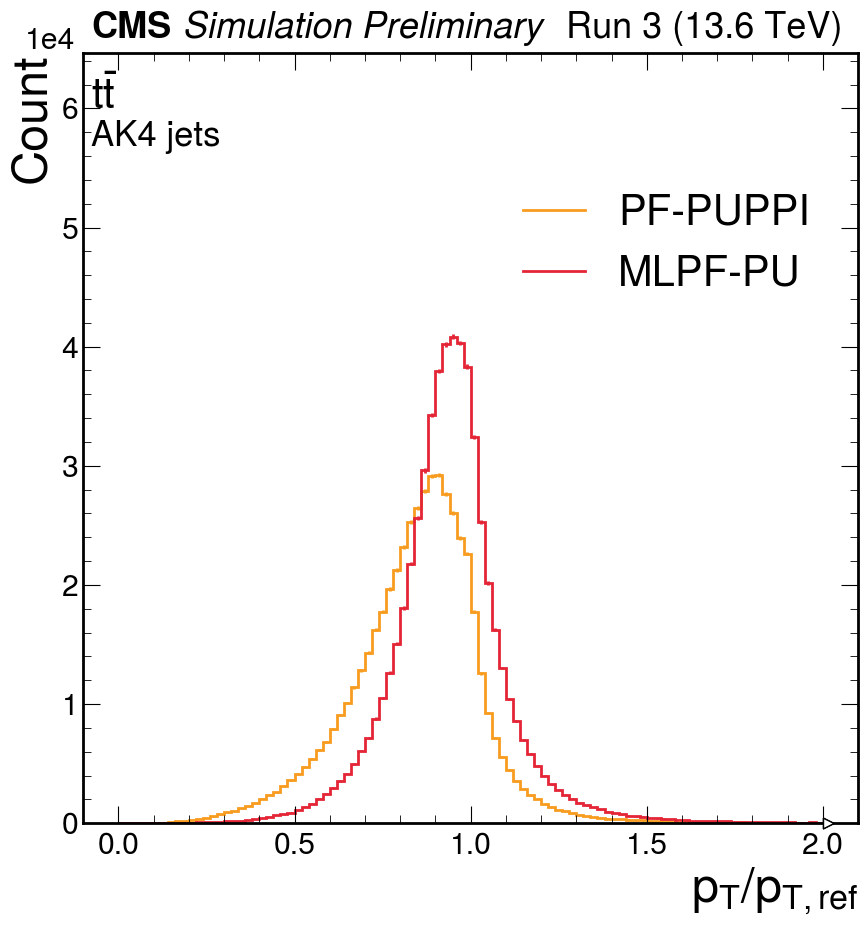

In [19]:
jet_response_plot()
plt.savefig("{}/ak4_jet_pt_ratio.pdf".format(outpath))

In [20]:
stats_pu_pf = []
stats_pu_mlpf = []
for pt_bins in pt_bins_for_pu:
    pu_bins = [(55,60),(60,65),(65,70),(70,75)]
    for _bl, _bh in pu_bins:
        s_pf, s_mlpf = jet_response_plot(
            additional_cut=lambda data: ((data["Pileup_nTrueInt"]>=_bl) & (data["Pileup_nTrueInt"]<_bh)),
            additional_label=", $N_{PV}\in["+f"{_bl},{_bh}"+"]$",
            genjet_min_pt=pt_bins[0],
            genjet_max_pt=pt_bins[1],
        )
        stats_pu_pf.append((pt_bins, (_bl, _bh), s_pf))
        stats_pu_mlpf.append((pt_bins, (_bl, _bh), s_mlpf))
        plt.savefig("{}/ak4_jet_pt_ratio_pt{}to{}_pu{}to{}.pdf".format(outpath, pt_bins[0], pt_bins[1], _bl, _bh))
        plt.clf()

/opt/conda/lib/python3.11/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/conda/lib/python3.11/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/conda/lib/python3.11/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/conda/lib/python3.11/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/conda/lib/python3.11/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [21]:
import pandas
df_ptreso_pu_pf = pandas.DataFrame(stats_pu_pf, columns=["ptbin", "pubin", "stats"])
df_ptreso_pu_pf["response"] = [x[1]/x[0] if x[0]>0 else 0 for x in df_ptreso_pu_pf["stats"]]
df_ptreso_pu_pf["pubin_low"] = [x[0] for x in df_ptreso_pu_pf["pubin"]]

df_ptreso_pu_mlpf = pandas.DataFrame(stats_pu_mlpf, columns=["ptbin", "pubin", "stats"])
df_ptreso_pu_mlpf["response"] = [x[1]/x[0] if x[0]>0 else 0 for x in df_ptreso_pu_mlpf["stats"]]
df_ptreso_pu_mlpf["pubin_low"] = [x[0] for x in df_ptreso_pu_mlpf["pubin"]]

/tmp/ipykernel_2416019/2139040086.py:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(grp_pf[1]["pubin_low"], grp_pf[1]["response"], label=grp_pf[0], marker=markers[imrk], color=pf_color)


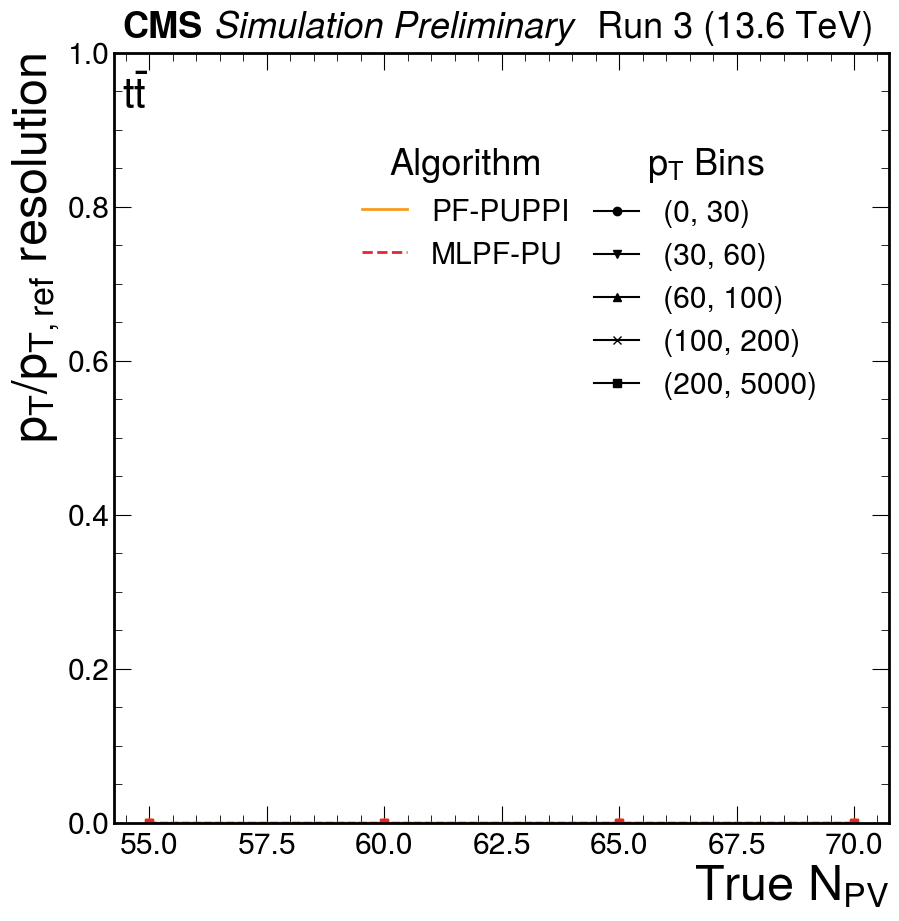

In [22]:
markers = ["o", "v", "^", "x", "s"]
imrk = 0
plt.figure()
ax = plt.axes()
leg_items_pu = []

for grp_pf, grp_mlpf in zip(df_ptreso_pu_pf.groupby("ptbin"), df_ptreso_pu_mlpf.groupby("ptbin")):
    plt.plot(grp_pf[1]["pubin_low"], grp_pf[1]["response"], label=grp_pf[0], marker=markers[imrk], color=pf_color)
    plt.plot(grp_mlpf[1]["pubin_low"], grp_mlpf[1]["response"], marker=markers[imrk], color=mlpf_color, ls="--")
    imrk += 1

handles, labels = ax.get_legend_handles_labels()

proxy_handles = [
    Line2D(
        [0], [0], # Placeholder data points
        marker=handle.get_marker(),
        color='black',
        linestyle=handle.get_linestyle(),
        label=label
    )
    for handle, label in zip(handles, labels)
]
leg1 = plt.legend(handles=proxy_handles, title=r"p$_{T}$ Bins", loc=(0.6, 0.53))
ax.add_artist(leg1)

legend2_handles = [
    Line2D([0], [0], color=pf_color, lw=2, label='PF-PUPPI'),
    Line2D([0], [0], color=mlpf_color, lw=2, linestyle='--', label='MLPF-PU')
]

plt.legend(handles=legend2_handles, title="Algorithm", loc=(0.3, 0.7))

plt.xlabel("True $N_{PV}$")
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.ylabel(plot_utils.labels["pt_response_iqr_median"])
plt.ylim(0,1.0)
plt.savefig("{}/ak4_jet_response_iqr_over_median_vs_npv.pdf".format(outpath, _bl, _bh))

### AK8

/tmp/ipykernel_2416019/826504444.py:4: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


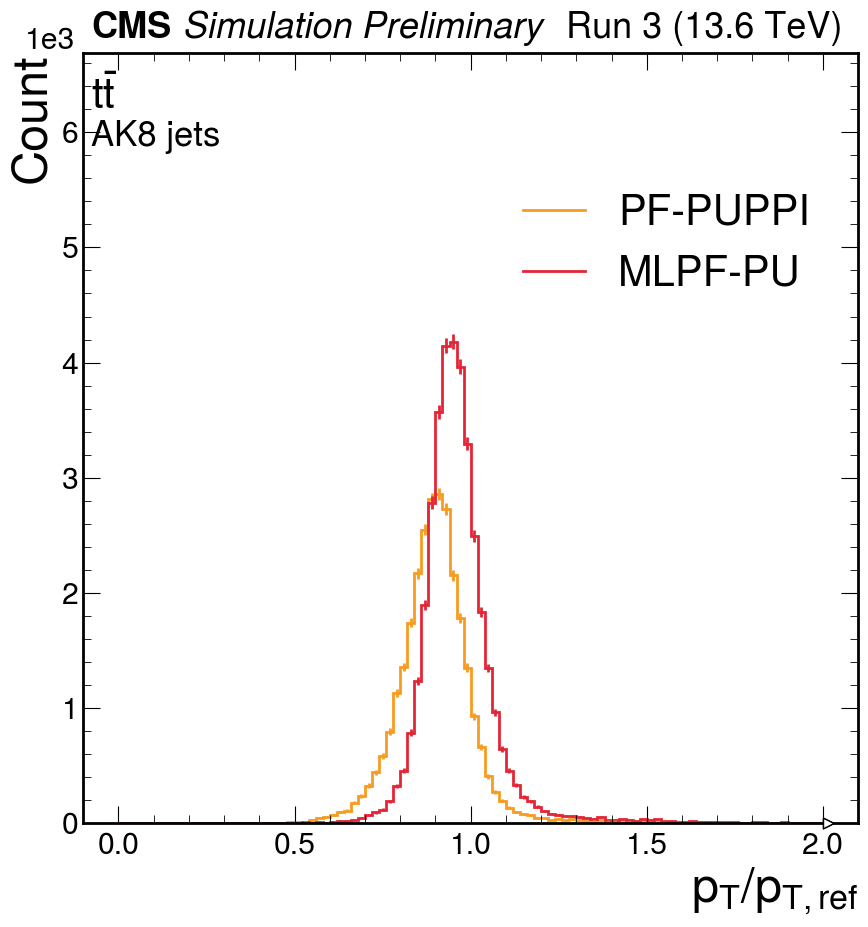

In [23]:
jet_response_plot(jet_pt="FatJet_pt_raw", gen_jet_pt="GenJetAK8_pt", gen_jet_idx="FatJet_genJetAK8Idx", jet_label=jet_label_ak8)
plt.savefig("{}/ak8_jet_pt_ratio.pdf".format(outpath))

In [24]:
def compute_iqr(data):
    p75 = np.percentile(data, 75)
    p25 = np.percentile(data, 25)
    return p75-p25

In [25]:
def get_response_in_bins(
    label_gjidx="Jet_genJetIdx", label_rjpt="Jet_pt_raw", label_gjpt="GenJet_pt",
    jet_bins=jet_bins,
    fn="ak4",
    title=jet_label_ak4,
    ):
    response_bins = np.linspace(0, 2, 100)
    
    med_vals_pf = []
    iqr_vals_pf = []
    mean_vals_pf = []
    sigma_vals_pf = []
    match_vals_pf = []
    
    med_vals_mlpf = []
    iqr_vals_mlpf = []
    mean_vals_mlpf = []
    sigma_vals_mlpf = []
    match_vals_mlpf = []

    
    for ibin in range(len(jet_bins)-1):
        min_pt = jet_bins[ibin]
        max_pt = jet_bins[ibin+1]
    
        msk = data_baseline[label_gjidx]!=-1
        matched_gj = data_baseline[label_gjpt][data_baseline[label_gjidx][msk]]
        jet_response_pf = data_baseline[label_rjpt][msk] / matched_gj
        jet_response_pf = awkward.flatten(jet_response_pf[(matched_gj>=min_pt) & (matched_gj<max_pt)])
        all_gj_pt = data_baseline[label_gjpt]
        sel_gj_pt = all_gj_pt[(all_gj_pt>=min_pt) & (all_gj_pt<max_pt)]
        match_vals_pf.append(awkward.count(jet_response_pf)/awkward.count(sel_gj_pt))

        msk = data_mlpf[label_gjidx]!=-1
        matched_gj = data_mlpf[label_gjpt][data_mlpf[label_gjidx][msk]]
        jet_response_mlpf = data_mlpf[label_rjpt][msk] / matched_gj
        jet_response_mlpf = awkward.flatten(jet_response_mlpf[(matched_gj>=min_pt) & (matched_gj<max_pt)])
        all_gj_pt = data_mlpf[label_gjpt]
        sel_gj_pt = all_gj_pt[(all_gj_pt>=min_pt) & (all_gj_pt<max_pt)]
        match_vals_mlpf.append(awkward.count(jet_response_mlpf)/awkward.count(sel_gj_pt))

        med, iqr = plot_utils.med_iqr(jet_response_pf)
        med_vals_pf.append(med)
        iqr_vals_pf.append(iqr)
        
        mean, sigma = compute_scale_res(jet_response_pf)
        mean_vals_pf.append(mean)
        sigma_vals_pf.append(sigma)
        
        plt.figure()
        ax = plt.axes()
        plt.plot([], [])
        plt.hist(
            jet_response_pf,
            bins=response_bins,
            histtype="step", lw=2,
            label="PF: ${:.2f}\pm{:.2f}$".format(med, iqr)
        );
    
        med, iqr = plot_utils.med_iqr(jet_response_mlpf)
        med_vals_mlpf.append(med)
        iqr_vals_mlpf.append(iqr)
        
        mean, sigma = compute_scale_res(jet_response_mlpf)
        mean_vals_mlpf.append(mean)
        sigma_vals_mlpf.append(sigma)       
        
        plt.hist(
            jet_response_mlpf,
            bins=response_bins,
            histtype="step", lw=2,
            label="MLPF-PU: ${:.2f}\pm{:.2f}$".format(med, iqr)
        );
        
        plt.legend(loc=1, title="{}, ${} < p_T < {}$".format(title, min_pt, max_pt))
        plt.ylim(0, 2*ax.get_ylim()[1])
        cms_label(ax)
        plt.xlabel(plot_utils.labels["pt_response"])
        plt.ylabel("Count")
        plt.savefig("{}/{}_jet_response_bin_{}.pdf".format(outpath, fn, ibin))
        if ibin>0:
            plt.clf()
            
    return (
        (med_vals_pf, iqr_vals_pf, match_vals_pf),
        (med_vals_mlpf, iqr_vals_mlpf, match_vals_mlpf),
        (mean_vals_pf, sigma_vals_pf),
        (mean_vals_mlpf, sigma_vals_mlpf),
    )

/tmp/ipykernel_2416019/826504444.py:4: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))
/tmp/ipykernel_2416019/826504444.py:4: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))
/tmp/ipykernel_2416019/826504444.py:4: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))
/tmp/ipykernel_2416019/826504444.py:4: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))
/tmp/ipykernel_2416019/826504444.py:4: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))
/tmp/ipykernel_2416019/826504444.py:4: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))
/tmp/ipykernel_2416019/826504444.py:4: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-((x -

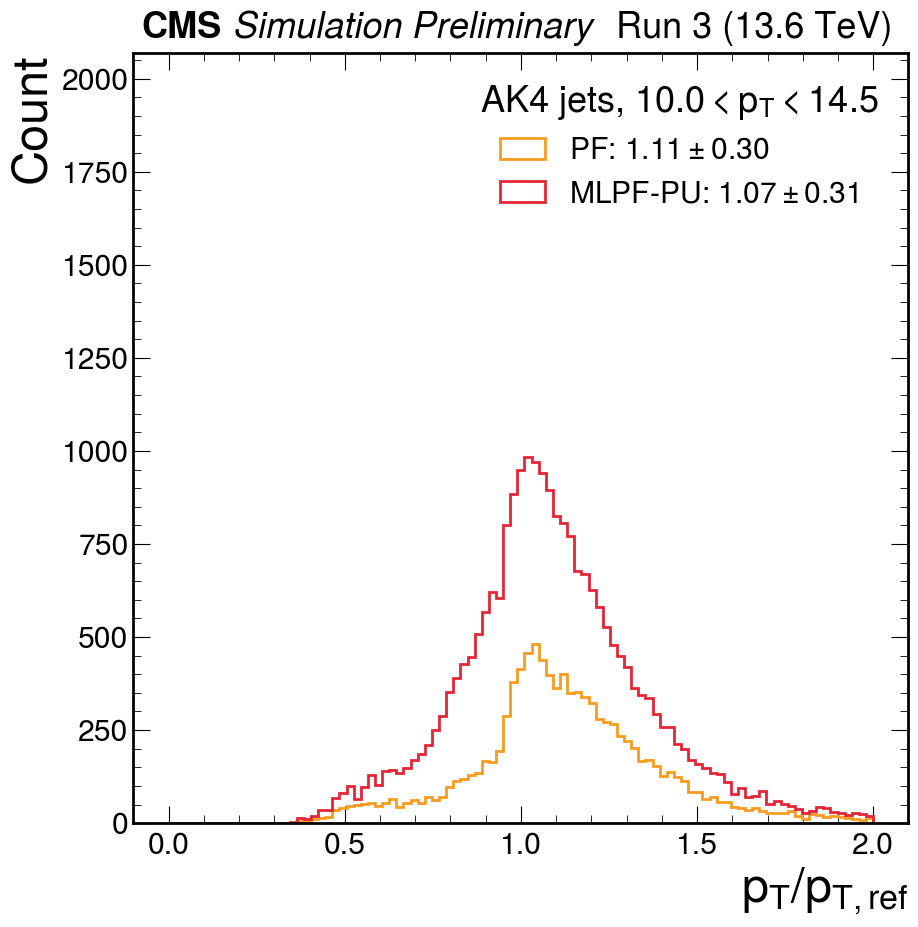

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [26]:
stats_pf, stats_mlpf, stats_pf_fit, stats_mlpf_fit = get_response_in_bins()

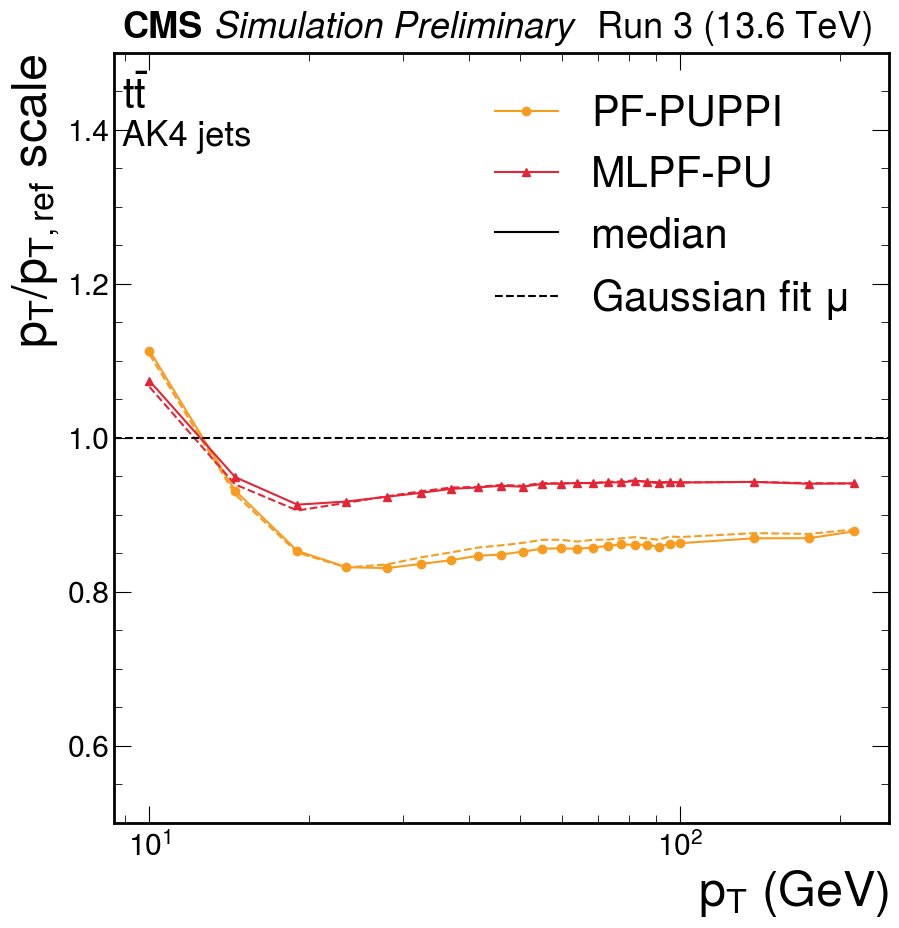

In [27]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])
l = plt.plot(jet_bins[:-1], np.array(stats_pf[0]), marker="o", label="PF-PUPPI")
plt.plot(jet_bins[:-1], np.array(stats_pf_fit[0]), color=l[0].get_color(), ls="--")
l = plt.plot(jet_bins[:-1], np.array(stats_mlpf[0]), marker="^", label="MLPF-PU")
plt.plot(jet_bins[:-1], np.array(stats_mlpf_fit[0]), color=l[0].get_color(), ls="--")

plt.xscale("log")
plt.ylabel(plot_utils.labels["pt_response_median"])
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.axhline(1.0, color="black", ls="--")
plt.ylim(0.5, 1.5)
plt.xlabel(plot_utils.labels["pt"])

handles, labels = ax.get_legend_handles_labels()
median_line = Line2D([0], [0], color='black', linestyle='-', label='median')
fit_mean_line = Line2D([0], [0], color='black', linestyle='--', label='Gaussian fit $\mu$')
handles.extend([median_line, fit_mean_line])
plt.legend(loc="best", handles=handles, fontsize=legend_fontsize)

plt.savefig("{}/ak4_jet_response_median.pdf".format(outpath))

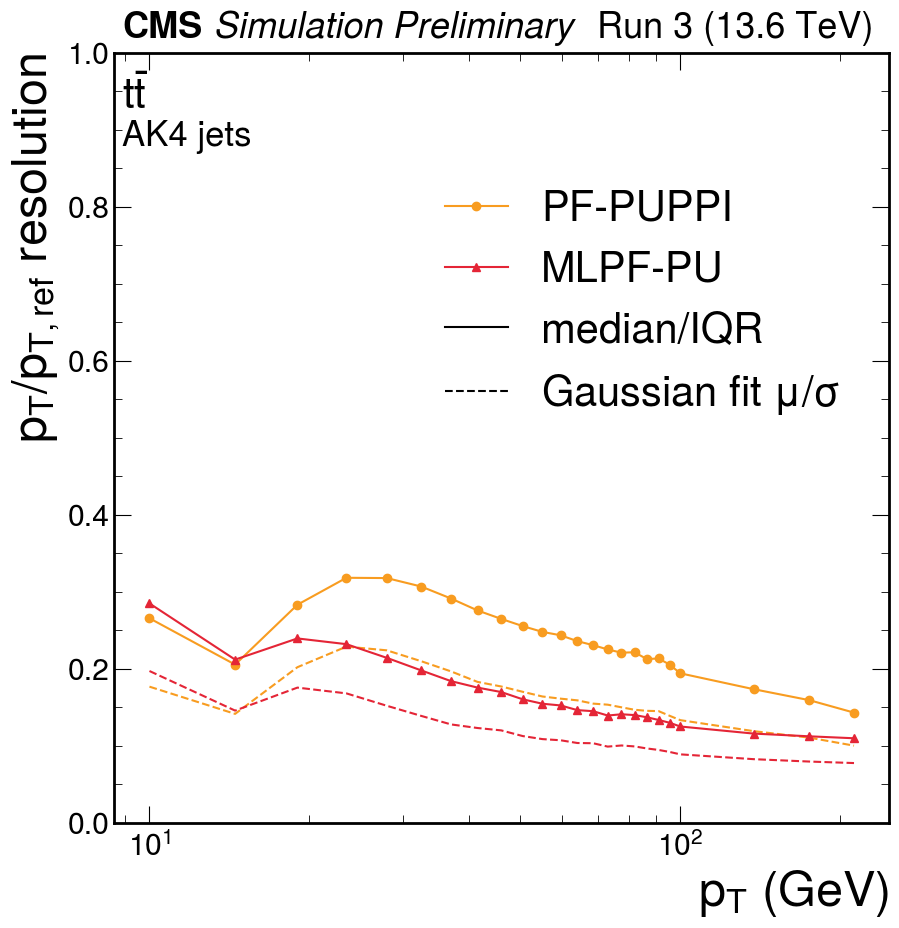

In [28]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])

l = plt.plot(
    jet_bins[:-1],
    np.array(stats_pf[1])/np.array(stats_pf[0]),
    label="PF-PUPPI", marker="o")


plt.plot(
    jet_bins[:-1],
    np.array(stats_pf_fit[1])/np.array(stats_pf_fit[0]),
    color=l[0].get_color(), ls="--")

l = plt.plot(
    jet_bins[:-1],
    np.array(stats_mlpf[1])/np.array(stats_mlpf[0]),
    label="MLPF-PU", marker="^")

plt.plot(
    jet_bins[:-1],
    np.array(stats_mlpf_fit[1])/np.array(stats_mlpf_fit[0]),
    color=l[0].get_color(), ls="--")

plt.xscale("log")
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)

handles, labels = ax.get_legend_handles_labels()
median_line = Line2D([0], [0], color='black', linestyle='-', label='median/IQR')
fit_mean_line = Line2D([0], [0], color='black', linestyle='--', label='Gaussian fit $\mu/\sigma$')
handles.extend([median_line, fit_mean_line])
plt.legend(loc=(0.4, 0.5), handles=handles, fontsize=legend_fontsize)

plt.ylabel(plot_utils.labels["pt_response_iqr_median"])
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(0, 1.0)
plt.xlabel(plot_utils.labels["pt"])
plt.savefig("{}/ak4_jet_response_iqr_over_median.pdf".format(outpath))

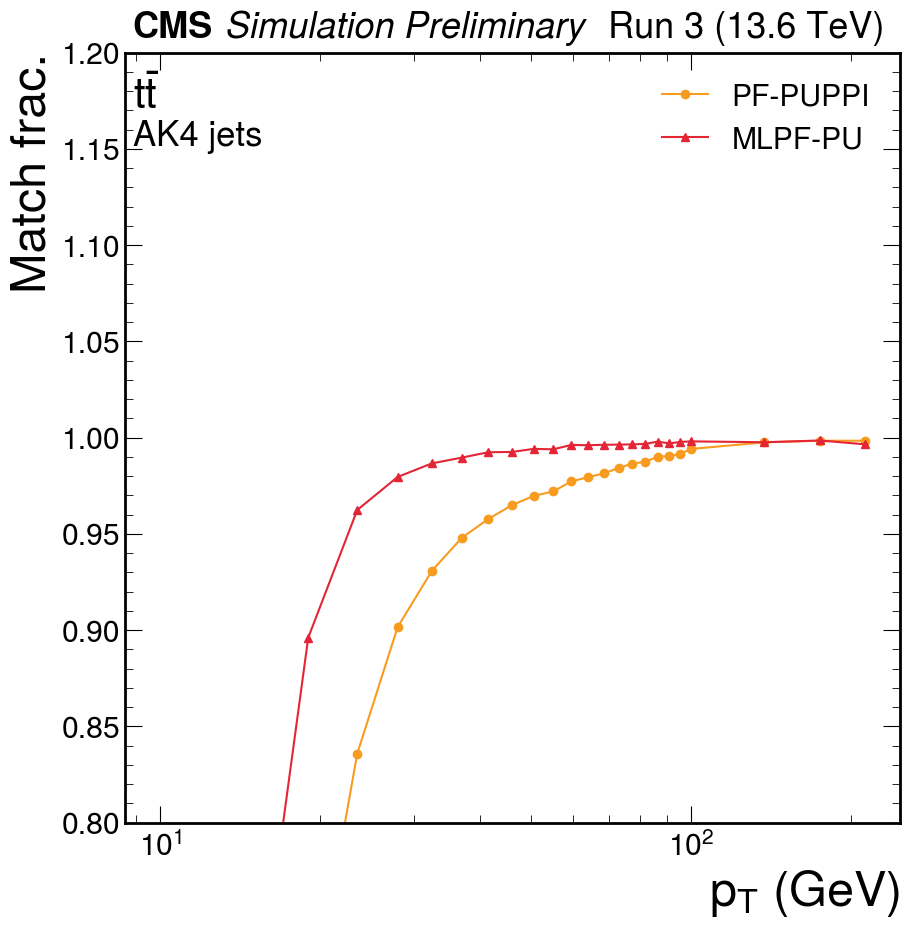

In [29]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])

plt.plot(
    jet_bins[:-1],
    np.array(stats_pf[2]),
    label="PF-PUPPI", marker="o")

plt.plot(
    jet_bins[:-1],
    np.array(stats_mlpf[2]),
    label="MLPF-PU", marker="^")

plt.xscale("log")
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.legend()
plt.ylabel(plot_utils.labels["match_frac"])
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(0.8, 1.2)
plt.xlabel(plot_utils.labels["pt"])
plt.savefig("{}/ak4_jet_match_frac.pdf".format(outpath))

## Fat jets

/tmp/ipykernel_2416019/826504444.py:4: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))
/tmp/ipykernel_2416019/826504444.py:4: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))
/tmp/ipykernel_2416019/826504444.py:4: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))
/tmp/ipykernel_2416019/826504444.py:4: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


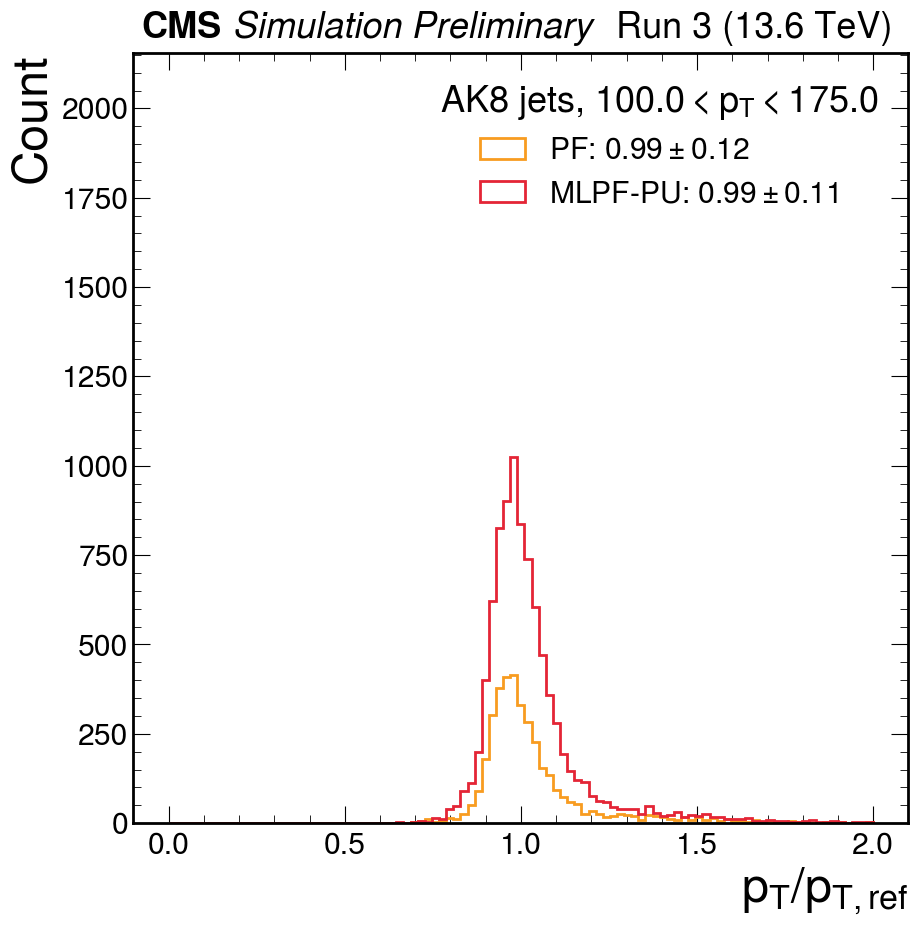

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [30]:
stats_pf, stats_mlpf, stats_pf_fit, stats_mlpf_fit = get_response_in_bins(
    label_gjidx="FatJet_genJetAK8Idx", label_rjpt="FatJet_pt_raw", label_gjpt="GenJetAK8_pt",
    jet_bins=fatjet_bins,
    fn="ak8",
    title=jet_label_ak8,
)

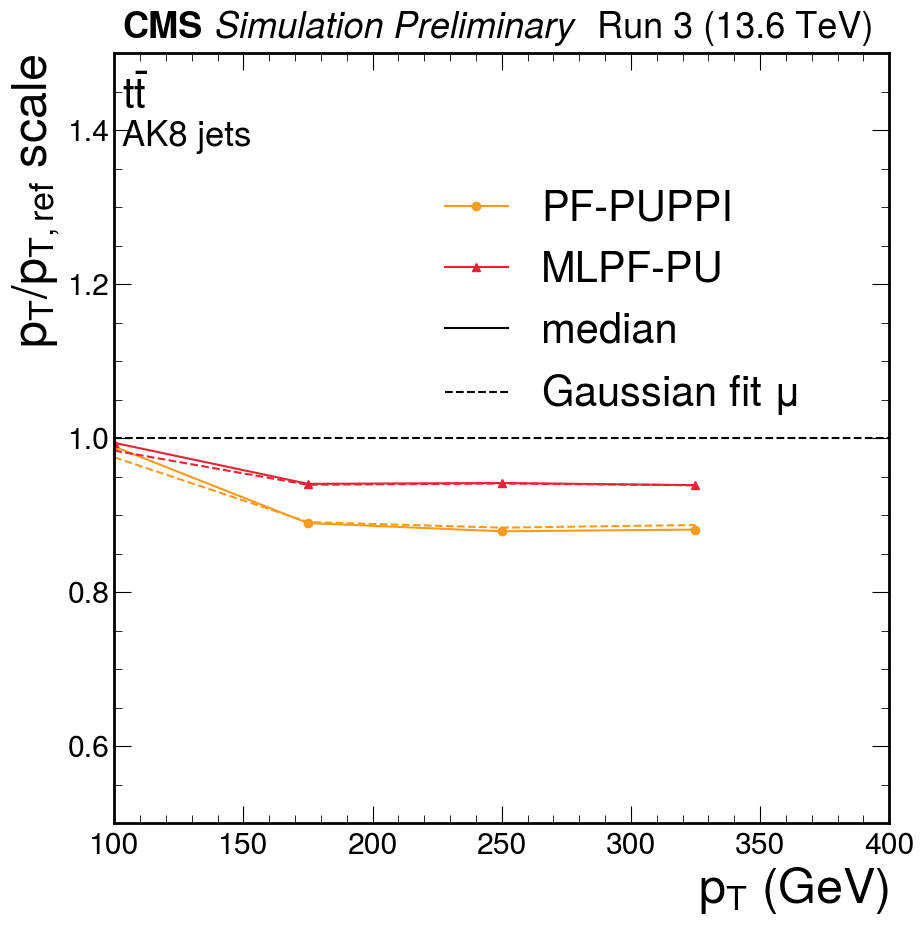

In [31]:
fig = plt.figure()
ax = plt.axes()

plt.plot([], [])
l = plt.plot(fatjet_bins[:-1], np.array(stats_pf[0]), marker="o", label="PF-PUPPI")
plt.plot(fatjet_bins[:-1], np.array(stats_pf_fit[0]), ls="--", color=l[0].get_color())

l = plt.plot(fatjet_bins[:-1], np.array(stats_mlpf[0]), marker="^", label="MLPF-PU")
plt.plot(fatjet_bins[:-1], np.array(stats_mlpf_fit[0]), ls="--", color=l[0].get_color())

#plt.xscale("log")
plt.legend(loc="best", fontsize=legend_fontsize)
plt.ylabel(plot_utils.labels["pt_response_median"])
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak8, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.axhline(1.0, color="black", ls="--")
plt.ylim(0.5, 1.5)
plt.xlim(fatjet_bins[0], fatjet_bins[-1]) 
plt.xlabel(plot_utils.labels["pt"])

handles, labels = ax.get_legend_handles_labels()
median_line = Line2D([0], [0], color='black', linestyle='-', label='median')
fit_mean_line = Line2D([0], [0], color='black', linestyle='--', label='Gaussian fit $\mu$')
handles.extend([median_line, fit_mean_line])
plt.legend(loc=(0.4, 0.5), handles=handles, fontsize=legend_fontsize)

plt.savefig("{}/ak8_jet_response_median.pdf".format(outpath))

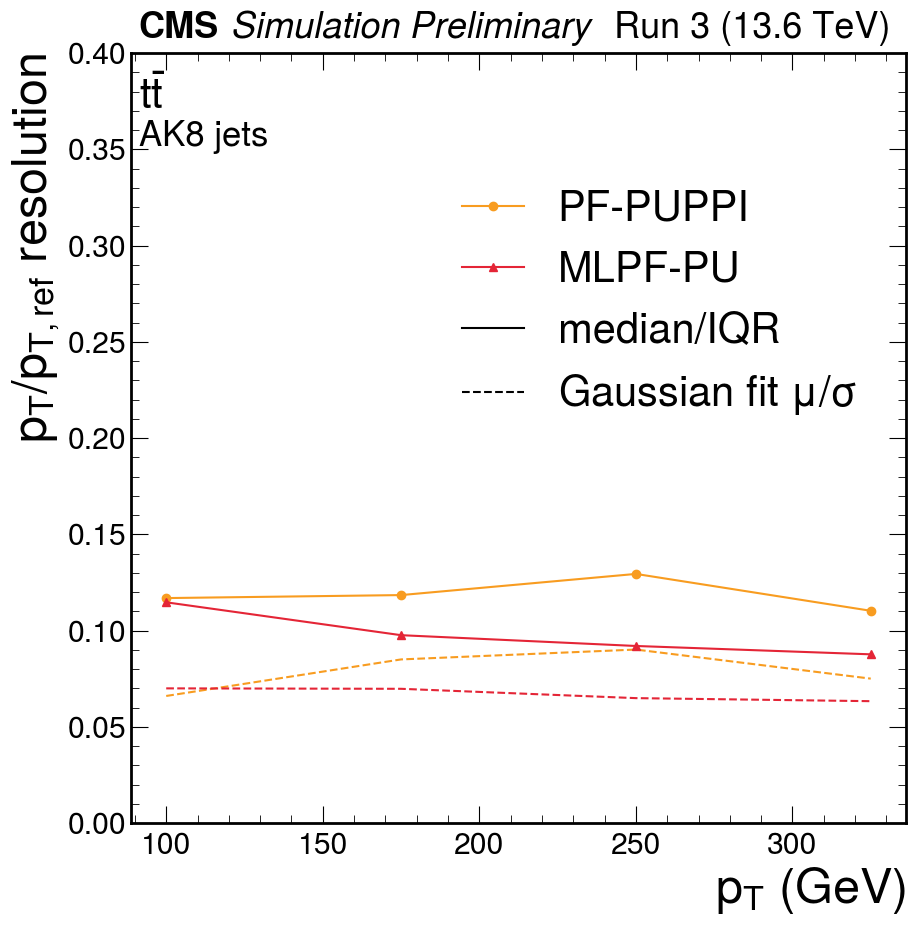

In [32]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])

l = plt.plot(
    fatjet_bins[:-1],
    np.array(stats_pf[1])/np.array(stats_pf[0]),
    label="PF-PUPPI", marker="o")
plt.plot(
    fatjet_bins[:-1],
    np.array(stats_pf_fit[1])/np.array(stats_pf_fit[0]),
    ls="--", color=l[0].get_color())

l = plt.plot(
    fatjet_bins[:-1],
    np.array(stats_mlpf[1])/np.array(stats_mlpf[0]),
    label="MLPF-PU", marker="^")
plt.plot(
    fatjet_bins[:-1],
    np.array(stats_mlpf_fit[1])/np.array(stats_mlpf_fit[0]),
    ls="--", color=l[0].get_color())

cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.ylabel(plot_utils.labels["pt_response_iqr_median"])
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak8, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(0, 0.4)
plt.xlabel(plot_utils.labels["pt"])

handles, labels = ax.get_legend_handles_labels()
median_line = Line2D([0], [0], color='black', linestyle='-', label='median/IQR')
fit_mean_line = Line2D([0], [0], color='black', linestyle='--', label='Gaussian fit $\mu/\sigma$')
handles.extend([median_line, fit_mean_line])
plt.legend(loc=(0.4, 0.5), handles=handles, fontsize=legend_fontsize)

plt.savefig("{}/ak8_jet_response_iqr_over_median.pdf".format(outpath))

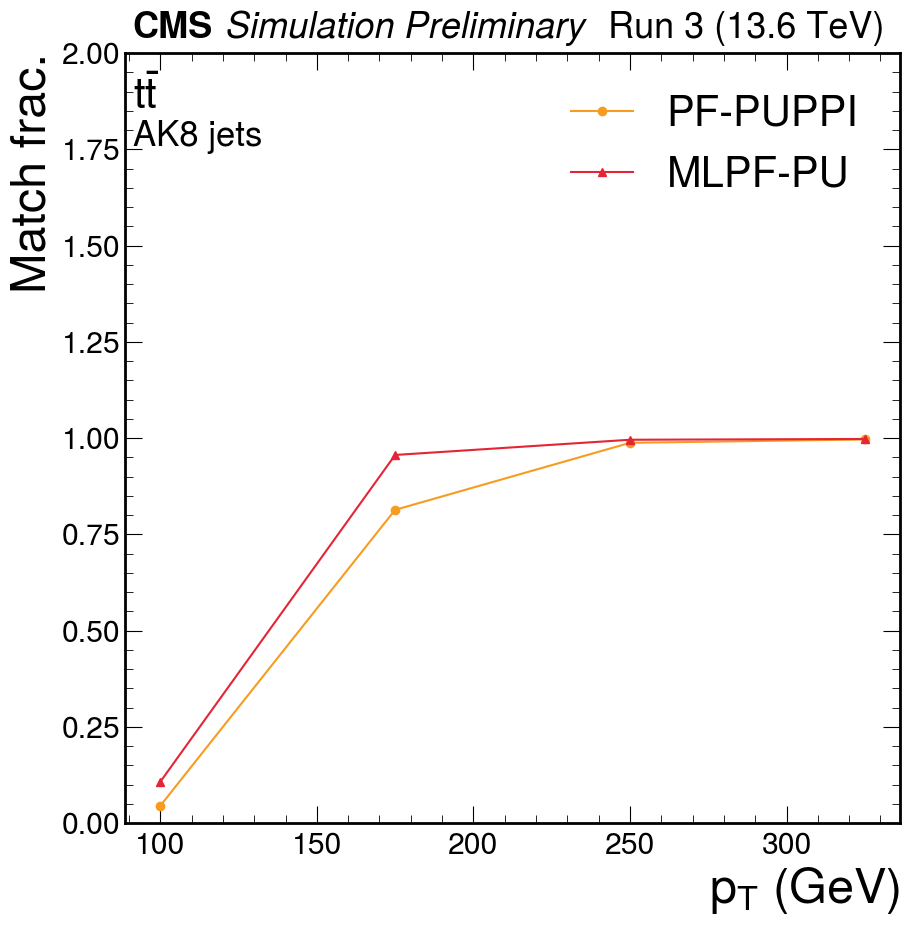

In [33]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])

plt.plot(
    fatjet_bins[:-1],
    np.array(stats_pf[2]),
    label="PF-PUPPI", marker="o")

plt.plot(
    fatjet_bins[:-1],
    np.array(stats_mlpf[2]),
    label="MLPF-PU", marker="^")

cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.ylabel(plot_utils.labels["match_frac"])
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak8, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(0, 2)
plt.xlabel(plot_utils.labels["pt"])
plt.savefig("{}/ak8_jet_match_frac.pdf".format(outpath))

# MET

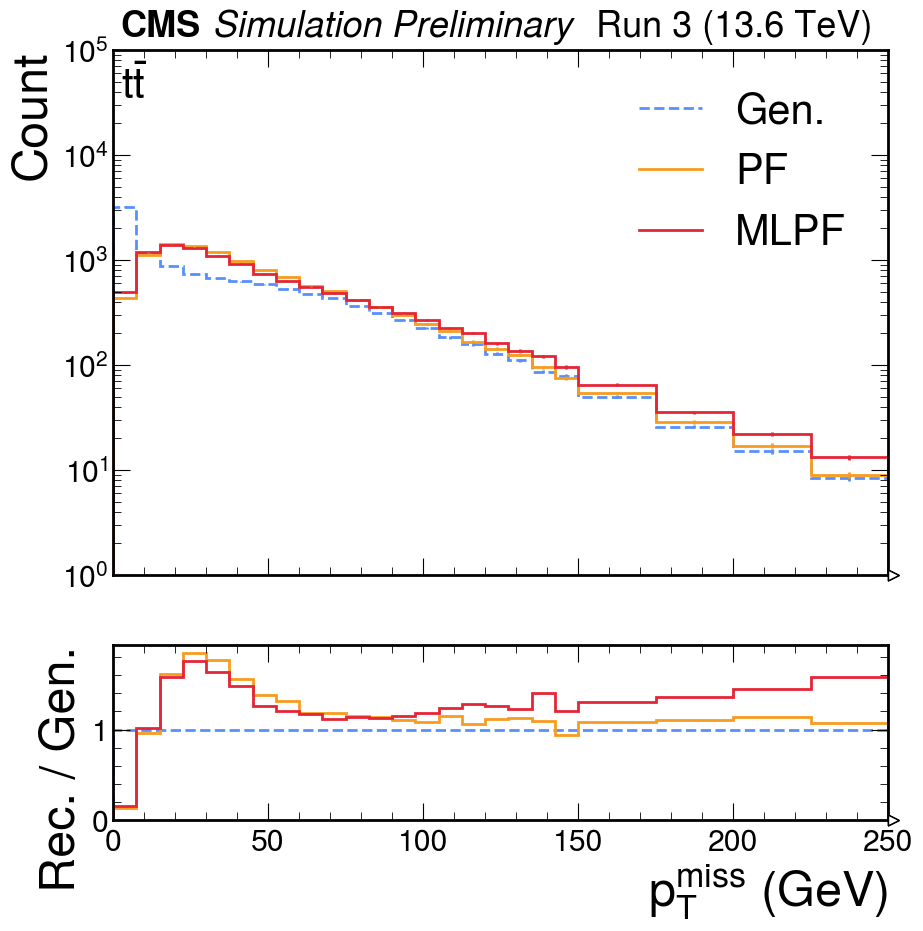

In [34]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True)

h0 = to_bh(data_baseline["GenMET_pt"], met_bins)
h1 = to_bh(data_baseline["PFMET_pt"], met_bins)
h2 = to_bh(data_mlpf["PFMET_pt"], met_bins)

plt.sca(a0)
x0 = mplhep.histplot(h0, histtype="step", lw=2, label="Gen.", binwnorm=1.0, ls="--")
x1 = mplhep.histplot(h1, histtype="step", lw=2, label="PF", binwnorm=1.0, ls="-")
x2 = mplhep.histplot(h2, histtype="step", lw=2, label="MLPF", binwnorm=1.0, ls="-")

plt.yscale("log")
cms_label(a0)
sample_label(a0, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
handles, labels = a0.get_legend_handles_labels()
handles = [x0[0].stairs, x1[0].stairs, x2[0].stairs]

a0.legend(handles, labels, loc="best", fontsize=legend_fontsize)
plt.ylim(1, 10**5)
plt.ylabel("Count")

plt.sca(a1)
mplhep.histplot(h0 / h0, histtype="step", lw=2, ls="--")
mplhep.histplot(h1 / h0, histtype="step", lw=2, ls="-")
mplhep.histplot(h2 / h0, histtype="step", lw=2, ls="-")

if folder == "QCD_PU":
    plt.ylim(-60, 60)
elif folder == "TTbar_PU":
    plt.ylim(-2,5)

plt.ylabel(reco_gen_ratio)
plt.xlabel(plot_utils.labels["met"])
plt.xlim(min(met_bins), max(met_bins))

plt.savefig("{}/met.pdf".format(outpath))

In [35]:
response_bins = np.linspace(0, 5, 41)
pv_bins_response = [10,50,100,150,200,250]

met_reso_pf = []
met_reso_mlpf = []

for ibin in range(len(pu_bins)):
    _bl = pu_bins[ibin][0]
    _bh = pu_bins[ibin][1]

    print(_bl, _bh)
    msk = ((data_baseline["Pileup_nTrueInt"]>=_bl) & (data_baseline["Pileup_nTrueInt"]<_bh) & (data_baseline["GenMET_pt"]>5))
    met_gen_pf = data_baseline["GenMET_pt"][msk]
    met_pf = data_baseline["PFMET_pt"][msk]
    met_response_pf = met_pf/met_gen_pf
    
    msk = ((data_mlpf["Pileup_nTrueInt"]>=_bl) & (data_mlpf["Pileup_nTrueInt"]<_bh) & (data_mlpf["GenMET_pt"]>5))
    met_gen_mlpf = data_mlpf["GenMET_pt"][msk]
    met_mlpf = data_mlpf["PFMET_pt"][msk]
    met_response_mlpf = met_mlpf/met_gen_mlpf

    plt.figure()
    ax = plt.axes()
    plt.plot([], [])
    plt.hist(met_response_pf, bins=response_bins, histtype="step")
    plt.hist(met_response_mlpf, bins=response_bins, histtype="step")
    cms_label(ax)
    sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
    ax.text(
        jet_label_coords_single[0],
        jet_label_coords_single[1],
        "$N_{PV}^{miss} \in [" + f"{_bl},{_bh}".format(_bl, _bh) + "]$",
        transform=ax.transAxes, fontsize=addtext_fontsize
    )

    mu_pf, std_pf = plot_utils.med_iqr(met_response_pf)
    mu_mlpf, std_mlpf = plot_utils.med_iqr(met_response_mlpf)
    met_reso_pf.append(std_pf/mu_pf if mu_pf>0 else 0)
    met_reso_mlpf.append(std_mlpf/mu_mlpf if mu_mlpf else 0)
    
    plt.ylim(0, ax.get_ylim()[1]*1.5)
    plt.xlabel(plot_utils.labels["met_response"])
    plt.ylabel("Count")
    plt.savefig("{}/met_genmet_{}_{}.pdf".format(outpath, _bl, _bh))
    plt.clf()

55 60
60 65
65 70
70 75


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

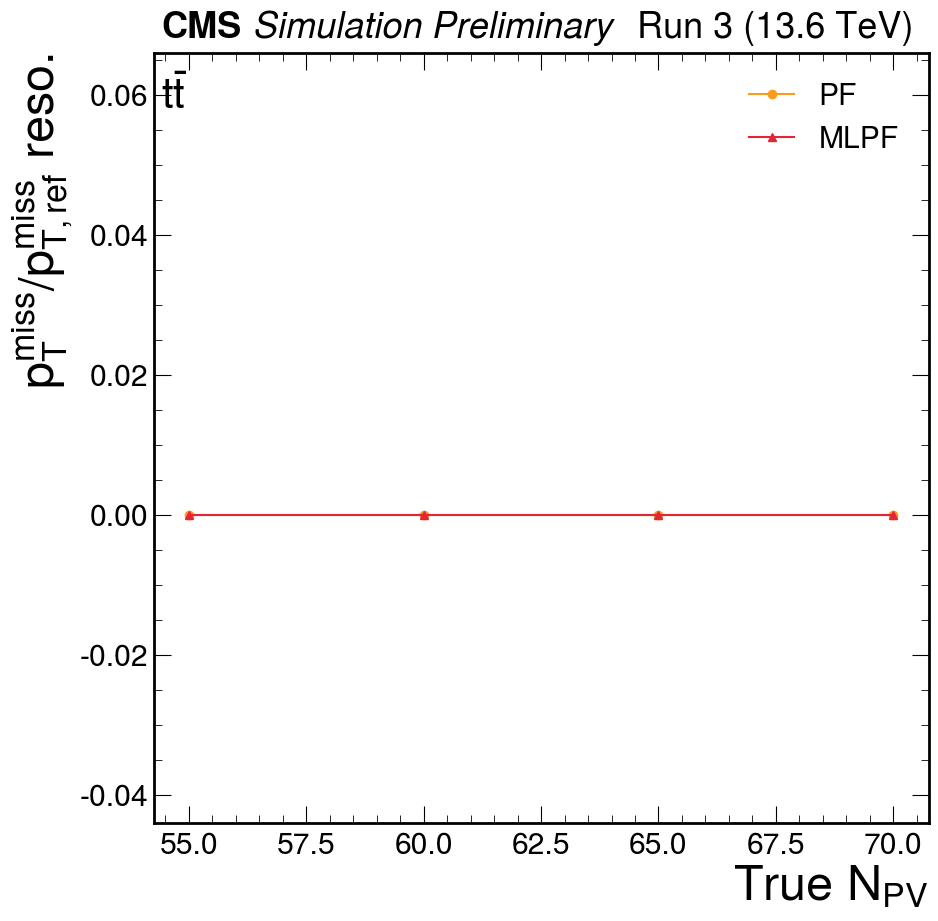

In [36]:
plt.figure()
ax = plt.axes()
plt.plot([], [])
pb = [p[0] for p in pu_bins]
plt.plot(pb, met_reso_pf, marker="o", label="PF")
plt.plot(pb, met_reso_mlpf, marker="^", label="MLPF")
plt.legend(loc="best")
yl = ax.get_ylim()
plt.ylim(yl[0]*0.8, yl[1]*1.2)
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.ylabel(plot_utils.labels["met_response"] + " reso.")
plt.xlabel("True $N_{PV}$")
plt.savefig("{}/met_npvs.pdf".format(outpath))